# Task 4: Preparing the IT Systems for the Demand 

The objective of this task is to identify peak demand periods in the booking system for HotelFlix, based on past booking data. By understanding when these peak demands occur, HotelFlix can ensure consistent and reliable IT system performance, preventing any interruptions or slowdowns during high-traffic periods. This analysis involves preparing and cleaning the data, visualizing historical booking trends to identify the most demanded weeks, and making predictions about future peak periods. By implementing this strategy, HotelFlix can optimize its IT infrastructure to handle peak loads efficiently, enhancing customer satisfaction and operational stability.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the CSV file
file_path = 'hotel_bookings.csv'
hotel_data = pd.read_csv(file_path)

# Handling missing values and data types
columns_to_convert = ['children', 'agent', 'company', 'adr', 'lead_time', 
                      'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 
                      'is_repeated_guest', 'previous_cancellations', 
                      'previous_bookings_not_canceled', 'required_car_parking_spaces', 
                      'total_of_special_requests']

for column in columns_to_convert:
    hotel_data[column] = pd.to_numeric(hotel_data[column], errors='coerce')

# Fill missing values with appropriate values
hotel_data.fillna({'children': 0, 'country': 'Unknown', 'agent': 0, 'company': 0}, inplace=True)

# Ensure that categorical columns contain only text
categorical_columns = ['hotel', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type']
for col in categorical_columns:
    hotel_data[col] = hotel_data[col].astype(str)

# Create the 'arrival_date' column by combining the existing columns.
hotel_data['arrival_date'] = pd.to_datetime(hotel_data['arrival_date_year'].astype(str) + '-' + 
                                    hotel_data['arrival_date_month'].astype(str) + '-' + 
                                    hotel_data['arrival_date_day_of_month'].astype(str), 
                                    format='%Y-%B-%d')

# Convert the 'reservation_status_date' column to datetime format
hotel_data['reservation_status_date'] = pd.to_datetime(hotel_data['reservation_status_date'])

# Calculate the number of days between reservation and arrival
hotel_data['days_between_booking_and_arrival'] = (hotel_data['arrival_date'] - hotel_data['reservation_status_date']).dt.days

# Add a column for the week of the year for the arrival date
hotel_data['arrival_week'] = hotel_data['arrival_date'].dt.isocalendar().week
hotel_data['arrival_year'] = hotel_data['arrival_date'].dt.isocalendar().year


In [2]:
# Group by week and count the number of reservations
weekly_demand = hotel_data.groupby(['arrival_year', 'arrival_week']).size().reset_index(name='number_of_bookings')

# Merge weekly_demand with the original DataFrame to ensure data alignment
hotel_data = pd.merge(hotel_data, weekly_demand, on=['arrival_year', 'arrival_week'], how='left')

# Numeric and categorical features
num_features = ["lead_time", "arrival_date_week_number", "arrival_date_day_of_month", "stays_in_weekend_nights",
                "stays_in_week_nights", "adults", "children", "is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled", "agent", "company", "required_car_parking_spaces", 
                "total_of_special_requests", "adr"]

cat_features = ["hotel", "meal", "market_segment", "distribution_channel", "reserved_room_type", "deposit_type", "customer_type"]

# Filter rows with null values in selected columns
hotel_data = hotel_data.dropna(subset=num_features + [col for col in cat_features if col in hotel_data.columns])

# Update cat_features to include only columns that exist in hotel_data
cat_features = [col for col in cat_features if col in hotel_data.columns]

We should evaluate each model

In [3]:
# Separate features and the target variable
X = hotel_data[num_features + cat_features]
y = hotel_data['number_of_bookings']

# Save the arrival_year and arrival_week columns
arrival_year_week = hotel_data[['arrival_year', 'arrival_week']]

# Preprocess numeric and categorical features
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

# Define the models
models = {
    'Random Forest': RandomForestRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'XGBoost': XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
}

# Evaluate the models
results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
    results[name] = np.sqrt(-scores)

# Display the results
print("\nModel\t\t\t\tRMSE (Mean)\tStandard Deviation")
print("------------------------------------------------------------")
for name, score in results.items():
    print(f'{name: <25} {score.mean():.2f}\t\t {score.std():.2f}')


Modelo				RMSE (Media)	Desviación Estándar
------------------------------------------------------------
Random Forest             130.14		 46.38
Decision Tree             152.41		 40.63
XGBoost                   139.59		 46.46


It is necessary to determine which model is the best after the evaluation

In [4]:
# Select the best model to predict the next year
best_model_name = min(results, key=lambda k: results[k].mean())
best_model = models[best_model_name]
print(f'\nBest model: {best_model_name}')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the models and make predictions
future_dates = pd.DataFrame({
    'arrival_year': [2024] * 52,
    'arrival_week': list(range(1, 53))
})

mean_values = hotel_data[num_features].mean().to_dict()
std_values = hotel_data[num_features].std().to_dict()

future_features = pd.DataFrame()
for col in num_features:
    future_features[col] = np.random.normal(mean_values[col], std_values[col], size=52)

for col in cat_features:
    future_features[col] = hotel_data[col].mode()[0]

future_features['arrival_year'] = future_dates['arrival_year']
future_features['arrival_week'] = future_dates['arrival_week']


Best model: Random Forest


Define a function to train and predict the models.

In [5]:
# Function to train the model and make predictions
def train_and_predict(model, name):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    pipeline.fit(X_train, y_train)
    
    future_features['arrival_year'] = future_dates['arrival_year']
    future_features['arrival_week'] = future_dates['arrival_week']
    
    future_dates_scaled = pipeline.named_steps['preprocessor'].transform(future_features)
    future_predictions = pipeline.named_steps['classifier'].predict(future_dates_scaled)
    
    future_demand = pd.DataFrame({
        'arrival_year': future_dates['arrival_year'],
        'arrival_week': future_dates['arrival_week'],
        'predicted_bookings': future_predictions
    })
    
    return future_demand

# Predict and store results for each model
predictions = {name: train_and_predict(model, name) for name, model in models.items()}

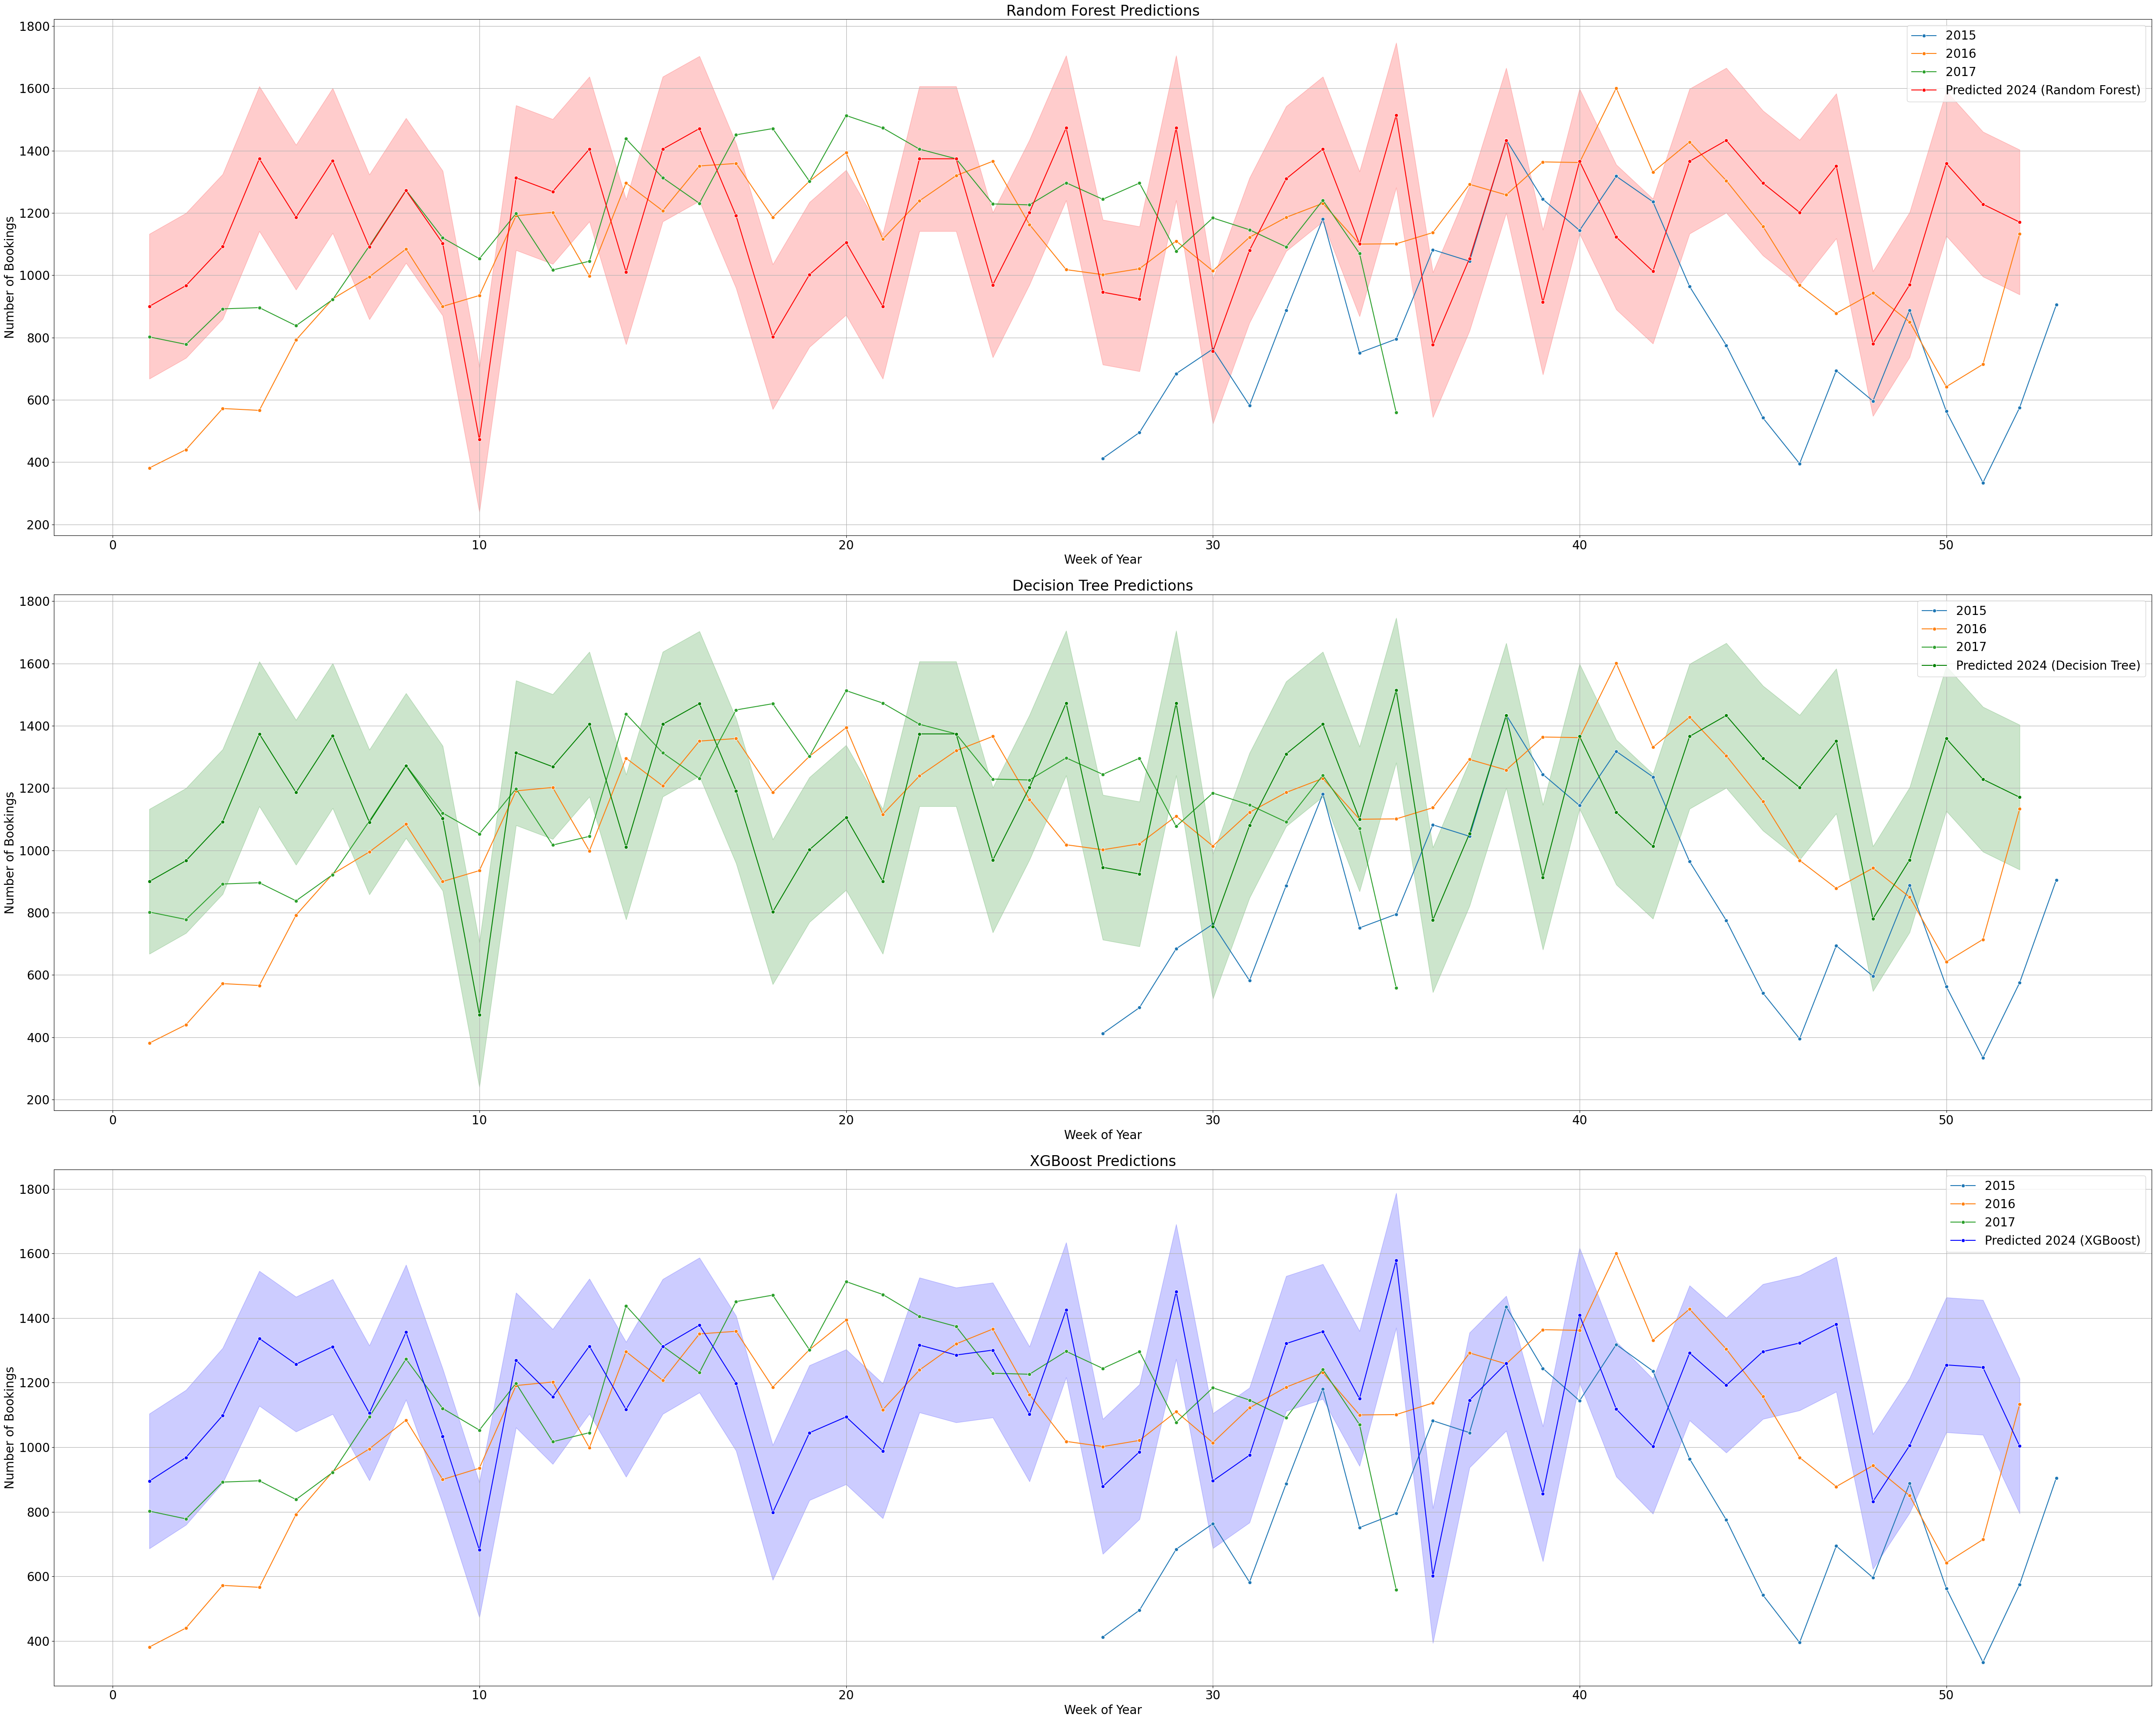


Top 5 Weeks with Highest Predicted Bookings in 2024 (Random Forest):
    arrival_year  arrival_week  predicted_bookings
34          2024            35             1514.13
28          2024            29             1473.00
25          2024            26             1473.00
15          2024            16             1471.00
43          2024            44             1433.09

Top 5 Weeks with Highest Predicted Bookings in 2024 (Decision Tree):
    arrival_year  arrival_week  predicted_bookings
34          2024            35             1514.13
28          2024            29             1473.00
25          2024            26             1473.00
15          2024            16             1471.00
43          2024            44             1433.09

Top 5 Weeks with Highest Predicted Bookings in 2024 (XGBoost):
    arrival_year  arrival_week  predicted_bookings
34          2024            35         1578.627930
28          2024            29         1481.726318
25          2024            26 

In [6]:
# Configure the plots to increase font sizes
plt.rcParams.update({'font.size': 20})

# Function to generate plots
def plot_predictions(predictions, title, color, position):
    plt.subplot(3, 1, position)
    sns.lineplot(data=weekly_demand, x='arrival_week', y='number_of_bookings', hue='arrival_year', palette='tab10', legend='full', marker='o')
    sns.lineplot(data=predictions, x='arrival_week', y='predicted_bookings', label=f'Predicted 2024 ({title})', color=color, marker='o')
    plt.fill_between(predictions['arrival_week'], 
                     predictions['predicted_bookings'] - predictions['predicted_bookings'].std(), 
                     predictions['predicted_bookings'] + predictions['predicted_bookings'].std(), 
                     color=color, alpha=0.2)
    plt.title(f'{title} Predictions')
    plt.xlabel('Week of Year')
    plt.ylabel('Number of Bookings')
    plt.legend()
    plt.grid(True)

plt.figure(figsize=(50, 40))

plot_predictions(predictions['Random Forest'], 'Random Forest', 'red', 1)
plot_predictions(predictions['Random Forest'], 'Decision Tree', 'green', 2)
plot_predictions(predictions['XGBoost'], 'XGBoost', 'blue', 3)

plt.tight_layout()
plt.show()

# Display the top 5 weeks with highest predicted demand in 2024 for each model
print("\nTop 5 Weeks with Highest Predicted Bookings in 2024 (Random Forest):")
print(predictions['Random Forest'].sort_values(by='predicted_bookings', ascending=False).head(5))

print("\nTop 5 Weeks with Highest Predicted Bookings in 2024 (Decision Tree):")
print(predictions['Random Forest'].sort_values(by='predicted_bookings', ascending=False).head(5))

print("\nTop 5 Weeks with Highest Predicted Bookings in 2024 (XGBoost):")
print(predictions['XGBoost'].sort_values(by='predicted_bookings', ascending=False).head(5))


---
Based on the analysis, the top 5 weeks with the highest predicted bookings in 2024 are weeks 34, 29, 26, and 16. To ensure the IT systems can handle the increased load during these peak periods, it is recommended to deploy a load balancer and add additional one EC2 instance during these weeks. 

This strategy will ensure that the booking system remains reliable and efficient, preventing any potential slowdowns or interruptions. By proactively scaling the infrastructure to match the predicted demand, HotelFlix can enhance customer satisfaction and maintain seamless operations during the busiest weeks of the year. This approach will ensure the IT department has everything planned and ready for these critical dates.